<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/meta_optimizercodechallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Create and inspect the data

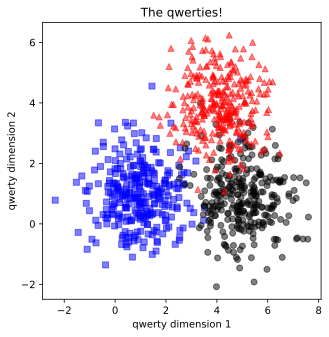

In [4]:
#create data
nPerClust=300
blur=1

A=[1,1]
B=[5,1]
C=[4,4]
#generate data
a=[A[0]+np.random.randn(nPerClust)*blur,A[1]+np.random.randn(nPerClust)*blur]
b=[B[0]+np.random.randn(nPerClust)*blur,B[1]+np.random.randn(nPerClust)*blur]
c=[C[0]+np.random.randn(nPerClust)*blur,C[1]+np.random.randn(nPerClust)*blur]
#true labels
labels_np=np.hstack((np.zeros((nPerClust)),np.ones((nPerClust)),2*np.ones((nPerClust))))
#concatanate into a matrix
data_np=np.hstack((a,b,c)).T
#convert to a pytorch tensor
data=torch.tensor(data_np).float()
labels=torch.tensor(labels_np).long() #note:'long' format for CCE
#show the data
fig=plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [5]:
#use scikitlearn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(data,labels,test_size=.1)
#then convert them into pytorch datasets(note:already converted to tensors)
train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)
#FINALLY, translate into dataloader objects
batchsize=16
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [6]:
print(f'there are {len(train_loader)}batches, each with {batchsize} samples')

there are 50batches, each with 16 samples


Create and Validate the model

In [7]:
#create a class for the model
def createTheQwertyNet(optimizerAlgo,learningrate):
  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()
      #input layer
      self.input=nn.Linear(2,8)
      ##hidden layer
      self.fc1=nn.Linear(8,8)
      ##output layer
      self.output=nn.Linear(8,3)
    def forward(self,x):
      x=F.relu(self.input(x))
      x=F.relu(self.fc1(x))
      x=self.output(x)
      return x
   # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optifun=getattr(torch.optim,optimizerAlgo)
  optimizer = torch.optim.SGD(net.parameters(),lr=learningrate)

  return net,lossfun,optimizer




A FUNCTION that trains the model

In [14]:
def function2trainTheModel(optimizerType,learningRates):
  #number of epochs
  numepochs=50
  #create a new model
  net,lossfun,optimizer=createTheQwertyNet(optimizerType,learningRates)
  #initialize Losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #iterate over epochs
  for epochi in range(numepochs):
    #iterate over training batches
    #switch on training mode
    net.train()
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat=net(X)
      loss=lossfun(yHat,y)
      #backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      #loss from this batch
      batchLoss.append(loss.item())
      #compute accuracy over the training batch
      accuracyPct=100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      batchAcc.append(accuracyPct)
    #now that we have trained through the batches, get their average training accuracy
    trainAcc.append(np.mean(batchAcc))
    #and get average losses across the batches
    losses[epochi]=np.mean(batchLoss)
    #test accuracy
    net.eval()
    X,y=next(iter(test_loader)) #extract X,y from test dataLoader
    with torch.no_grad(): #deactivates autograd
      yHat=net(X)
    #compute test accuracy
    testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))
    #epochs
  return trainAcc,testAcc,losses,net

Experiment

In [15]:
from typing_extensions import final
#variables to loop over
learningRates=np.logspace(np.log10(.0001),np.log10(.1),20)
optimTypes=['SGD','RMSprop','Adam']
#initialize performance matrix
finalPerformance=np.zeros((len(learningRates),len(optimTypes)))
#now for the experiment
for idx_o,opto in enumerate(optimTypes):
  for idx_l,lr in enumerate(learningRates):
    #create the model
    trainAcc,testAcc,losses,net=function2trainTheModel(opto,lr)
    finalPerformance[idx_l,idx_o]=np.mean(testAcc[-10:])

Plot the results!

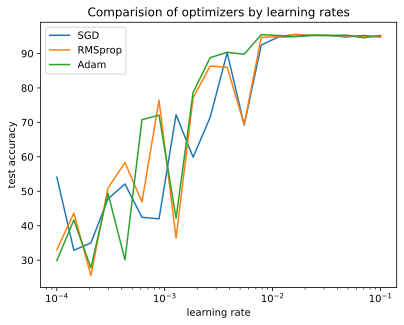

In [16]:
#plot the results!
plt.plot(learningRates,finalPerformance)
plt.xscale('log')
plt.xlabel('learning rate')
plt.ylabel('test accuracy')
plt.legend(optimTypes)
plt.title('Comparision of optimizers by learning rates')
plt.show()